# Introduction

CausalDataGenerator is a software that learns causal relationships based on a given data and causal relationships.

In this notebook, we will explain the case without discrete variables. See CausalBasedSimulator_discrete_variables.ipynb for an explanation of the case with discrete variables.

## Import and settings

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as st
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import graphviz as gv
from IPython.display import Markdown
import lingam

print([np.__version__, pd.__version__, gv.__version__, lingam.__version__])

np.set_printoptions(precision=3, suppress=True)
np.random.seed(100)


from lingam.experimental.cdg import CausalDataGenerator
    
np.random.seed(0)

['1.26.3', '2.2.2', '0.20.3', '1.8.3']


# Creating test data

## Causal graph

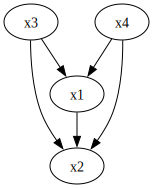

## Scatter matrix

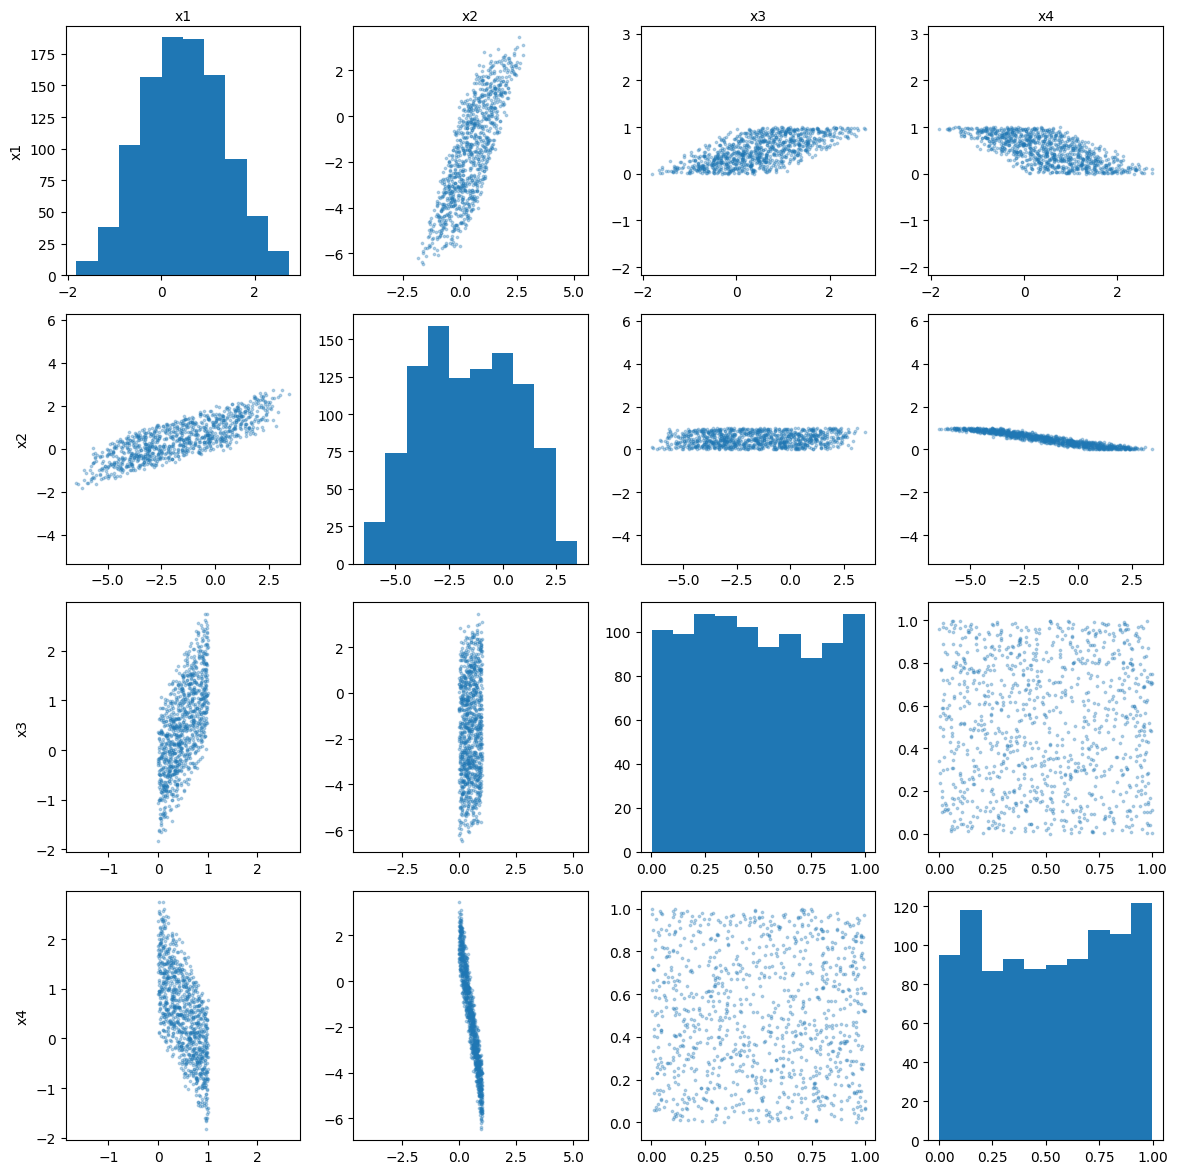

In [2]:
N = 1000

x3 = np.random.uniform(size=N)
x4 = np.random.uniform(size=N)
x1 = 2 * x3 - 2 * x4 + np.random.uniform(size=N)
x2 = 2 * x1 - 3 * x3 - 3 * x4 + np.random.uniform(size=N)

X = pd.DataFrame({"x1": x1, "x2": x2, "x3": x3, "x4": x4})

display(Markdown("## Causal graph"))
graph = gv.Digraph()
graph.edges([("x3", "x1"), ("x3", "x2"), ("x4", "x1"), ("x4", "x2"), ("x1", "x2")])
display(graph)

def draw_histogram(df, s=3, suptitle=None):
    fig, axes = plt.subplots(1, df.shape[1], figsize=(df.shape[1] * s, s))
    
    for i in range(df.shape[1]):
        axes[i].hist(df.iloc[:, i])
        axes[i].set_xlabel(df.columns[i])
        
    if suptitle is not None:
        plt.suptitle(suptitle)
        
    plt.tight_layout()
    plt.show()
    
def draw_scatter_matrix(true, pred, s=3, supxlabel="", supylabel="", diagonal_hist=True):
    n_cols = true.shape[1]
    
    fig, axes = plt.subplots(n_cols, n_cols, figsize=(n_cols * s, n_cols * s))
    
    for i, c in enumerate(true.columns):
        for j, c2 in enumerate(true.columns):
            if i == j and diagonal_hist is True:
                if true[c].dtype == "category":
                    axes[i, j].bar(*np.unique(true[c], return_counts=True), width=0.5)
                else:
                    axes[i, j].hist(true[c])
            else:
                axes[i, j].scatter(true[c], pred[c2], alpha=0.3, s=3)
                axes[i, j].axis("equal")
            
            if i == 0:
                axes[i, j].set_xlabel(c2)    
                axes[i, j].xaxis.set_label_position("top") 
            if j == 0:
                axes[i, j].set_ylabel(c)

    fig.supxlabel(supxlabel, va="top")
    fig.supylabel(supylabel)
    plt.tight_layout()
    plt.show()
    
display(Markdown("## Scatter matrix"))
draw_scatter_matrix(X, X)

# Fitting models to the data based on the given causal roles

For the data created, x1 has the causal role of "cause", x2 has the role of "effect", and x3 and x4 have the role of "adjustment". Run fit() with data and causal roles to estimate the "cause" and "effect" models.

In [3]:
gen = CausalDataGenerator()
gen.fit(X, "x1", "x2", adjustments=["x3", "x4"])

We have access to fitted models and errors. CausalDataGenerator uses linear regression by default for modeling "cause" and "effect". "gen.error_cause_" and "gen.error_effect_" contains the residuals of the regression.

In [4]:
display(gen.model_cause_)
gen.model_cause_.coef_, gen.model_cause_.intercept_

LinearRegression()

(array([ 1.97 , -1.986]), 0.5130127356616865)

In [5]:
display(gen.model_effect_)
gen.model_effect_.coef_, gen.model_effect_.intercept_

LinearRegression()

(array([ 2.046, -3.118, -2.932]), 0.4854354855461409)

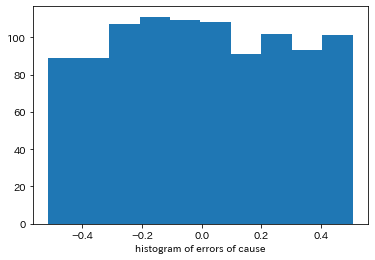

In [6]:
plt.hist(gen.error_cause_)
plt.xlabel("histogram of errors of cause")
plt.show()

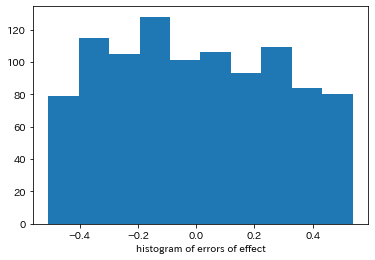

In [7]:
plt.hist(gen.error_effect_)
plt.xlabel("histogram of errors of effect")
plt.show()

## Change the model for fit()

You can change the model used by fit() from the default machine learning model by specifying a scikit-learn machine learning model in the `model_effect_` or `model_cause_` arguments.

In [8]:
model = Pipeline([
    ("preproc", StandardScaler()),
    ("estimator", MLPRegressor(max_iter=500))
])

param_grid = {
    "estimator__hidden_layer_sizes": [(10, 10), (10, 10, 10)],
}
model_effect = GridSearchCV(model, param_grid)

gen2 = CausalDataGenerator()
gen2.fit(X, "x1", "x2", adjustments=["x3", "x4"], model_effect=model_effect)

gen2.model_effect_

GridSearchCV(estimator=Pipeline(steps=[('preproc', StandardScaler()),
                                       ('estimator',
                                        MLPRegressor(max_iter=500))]),
             param_grid={'estimator__hidden_layer_sizes': [(10, 10),
                                                           (10, 10, 10)]})

# Data Generation

CausalDataGenerator can generate data using the result of fit().

In [9]:
data = gen.generate()
data

,x1,x2,x3,x4
0,0.723385,-1.564349,0.548814,0.592880
1,1.886335,2.226530,0.715189,0.010064
2,0.777030,-0.903124,0.602763,0.475826
3,-0.077254,-3.063911,0.544883,0.708770
4,1.364402,2.142326,0.423655,0.043975
...,...,...,...,...
995,-0.445523,-3.208281,0.097676,0.791282
996,0.133581,-3.006325,0.514922,0.721198
997,1.240222,-0.945112,0.938412,0.480108
998,-0.016890,-1.718505,0.228647,0.643864


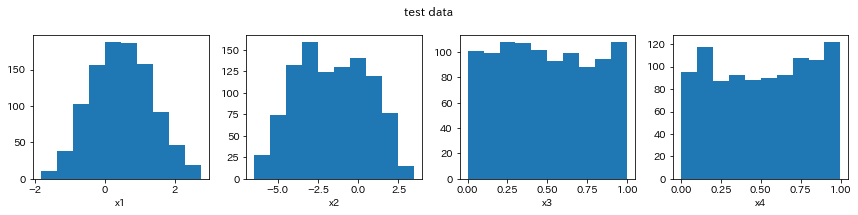

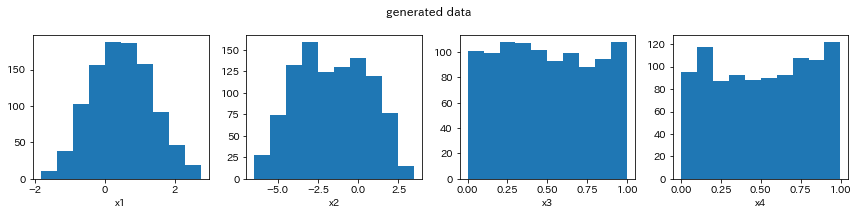

In [10]:
draw_histogram(X, suptitle="test data")
draw_histogram(data, suptitle="generated data")

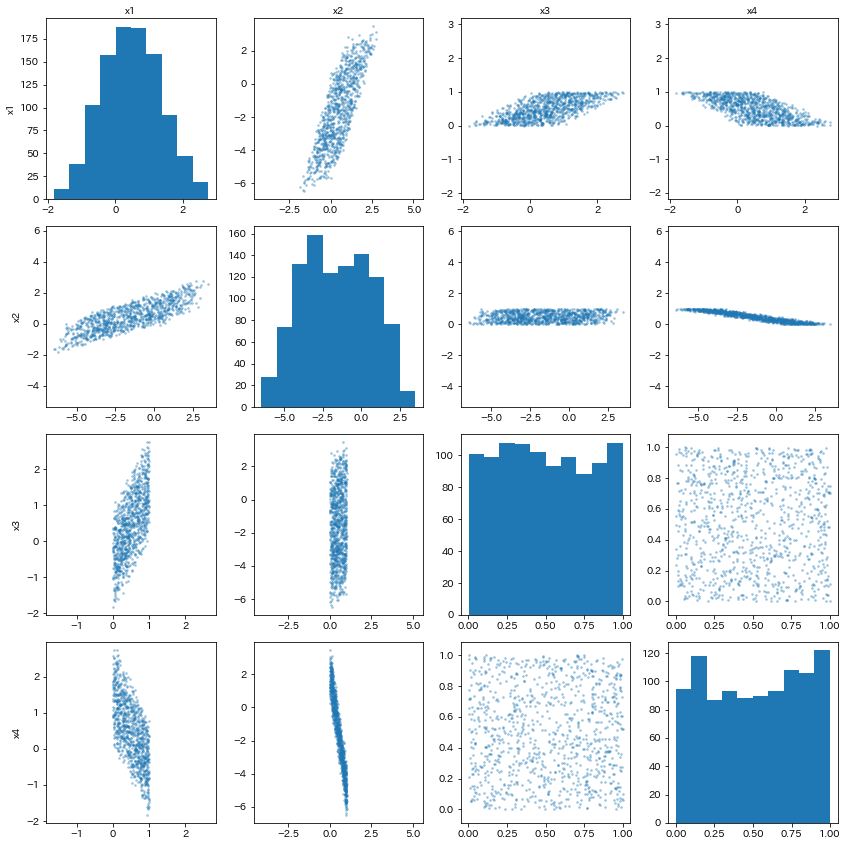

In [11]:
draw_scatter_matrix(data, data)

# Data generation with changing endogenous variables

In [12]:
data = gen.generate(interv_endog={"x1": np.ones(N)})

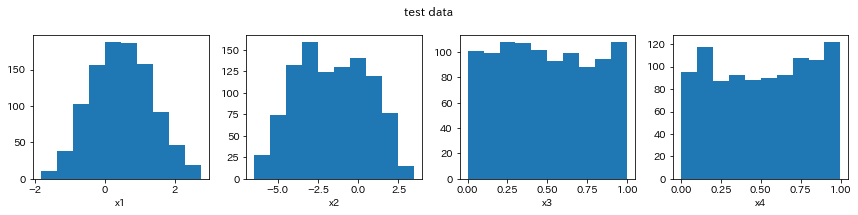

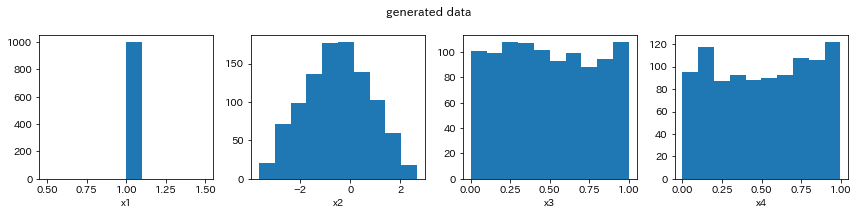

In [13]:
draw_histogram(X, suptitle="test data")
draw_histogram(data, suptitle="generated data")

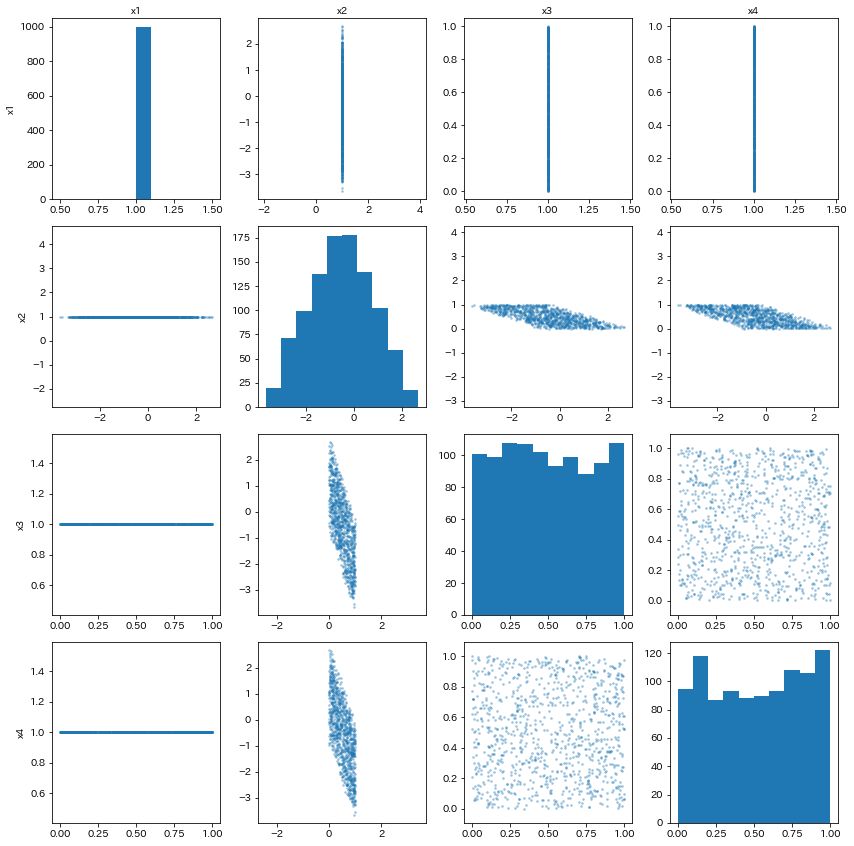

In [14]:
draw_scatter_matrix(data, data)

# Data generation with changing exogenous variables
Here, the noise is prepared using the estimated probability density function.

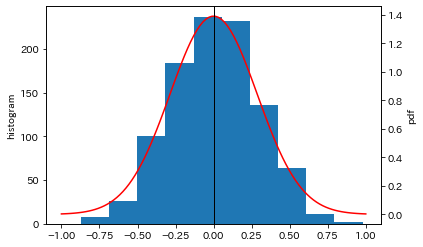

In [15]:
# Assume normal distribution for residuals of x1
params = st.norm.fit(gen.error_cause_, floc=0)
samples = st.norm(*params).rvs(X.shape[0])

plt.hist(samples)
plt.ylabel("histogram")
x = np.linspace(-1, 1, 100)
ax = plt.twinx()
ax.plot(x, st.norm(*params).pdf(x), color="red")
ax.set_ylabel("pdf")
plt.axvline(0, color="black", lw=1)
plt.show()

In [16]:
data = gen.generate(interv_exog={"x1": samples})

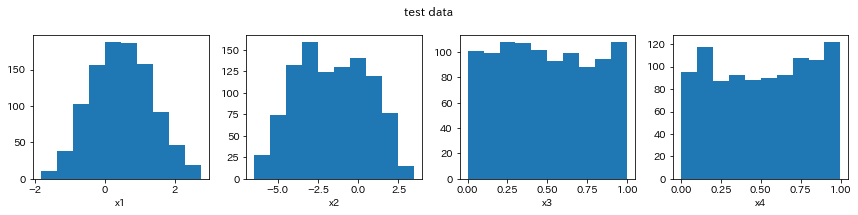

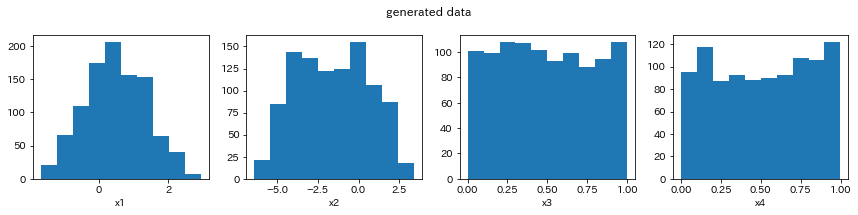

In [17]:
draw_histogram(X, suptitle="test data")
draw_histogram(data, suptitle="generated data")

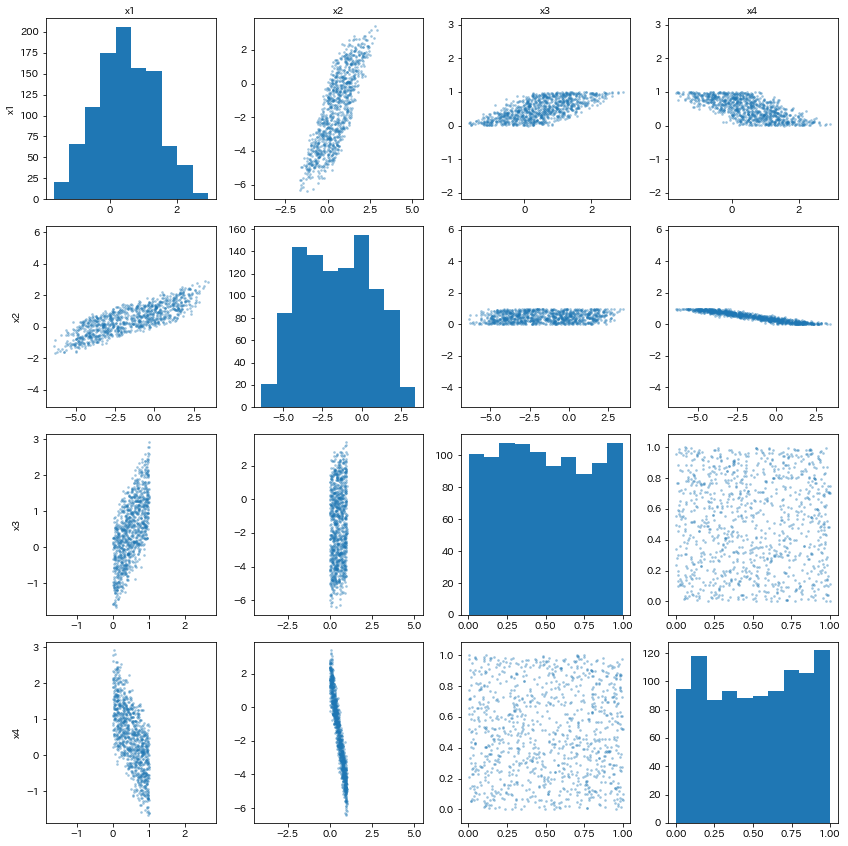

In [18]:
draw_scatter_matrix(data, data)

# Data generation with changing the effect model

In [19]:
# The arguments are explanatory variables, residuals and user-defined args.
# The output is the value of the generated "effect" variable.
def effect_model(X, error, args):
    # The explanatory variables for x2 are x1, x3, and x4.
    # The contents of X.columns are [cause, *adjustments]
    print(X.columns)
    
    generated = X @ args.coef_ + args.intercept_ + error
    return generated

# The user must provide "effect_model" as an argument. If necessary, "effect_model_args" can also be given.
data = gen.generate(effect_model=effect_model, effect_model_args=gen.model_effect_)

Index(['x1', 'x3', 'x4'], dtype='object')


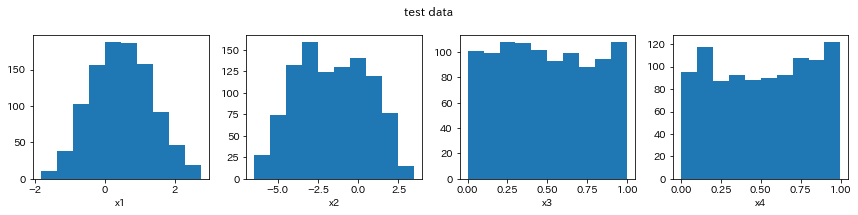

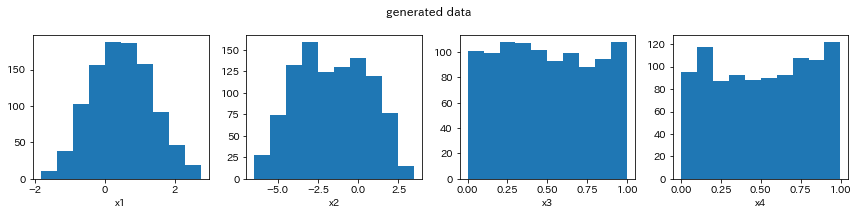

In [20]:
draw_histogram(X, suptitle="test data")
draw_histogram(data, suptitle="generated data")

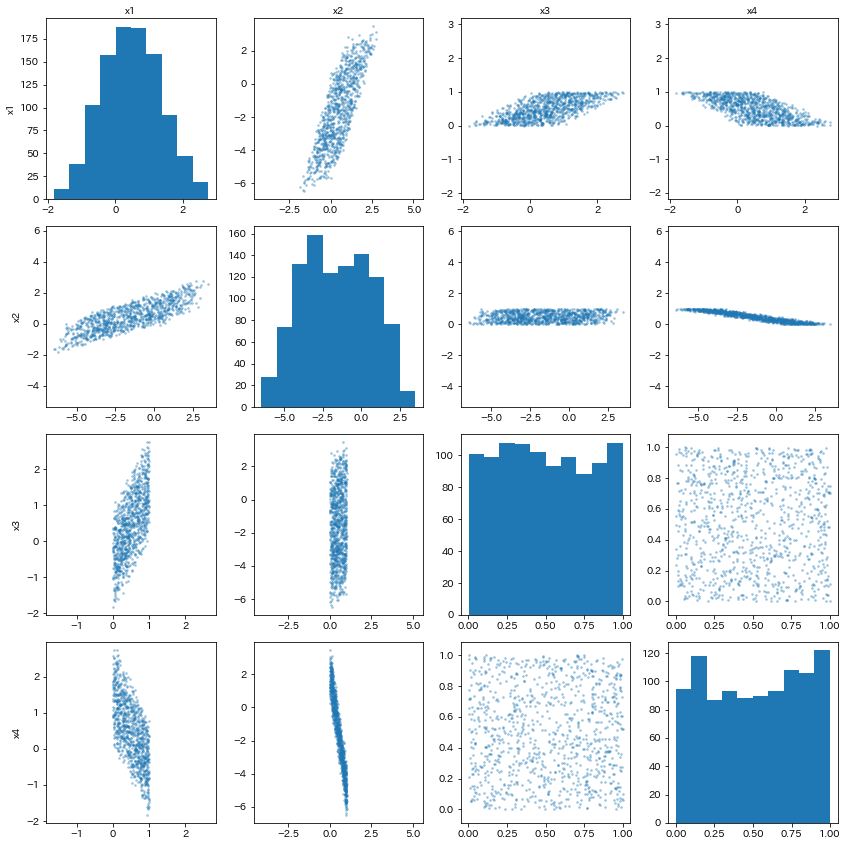

In [21]:
draw_scatter_matrix(data, data)

# Data generation with changing the cause model

In [22]:
def cause_model(X, error, args):
    # The explanatory variables for x1 are x3 and x4.
    # The contents of X.columns are [*adjustments]
    print(X.columns)
    
    # twice coefficient
    generated = X @ (args.coef_ * 2) + args.intercept_ + error
    return generated

data = gen.generate(cause_model=cause_model, cause_model_args=gen.model_cause_)

Index(['x3', 'x4'], dtype='object')


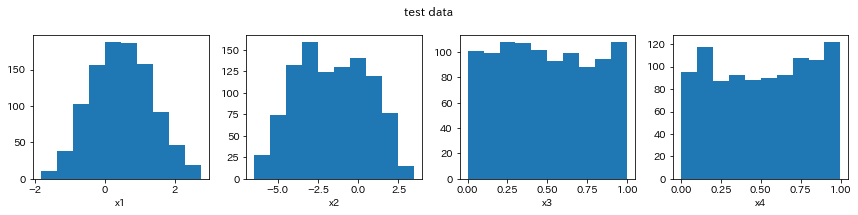

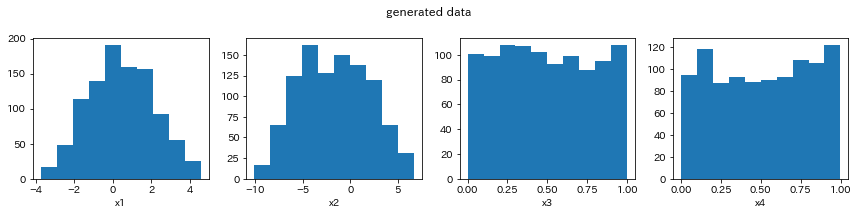

In [23]:
draw_histogram(X, suptitle="test data")
draw_histogram(data, suptitle="generated data")

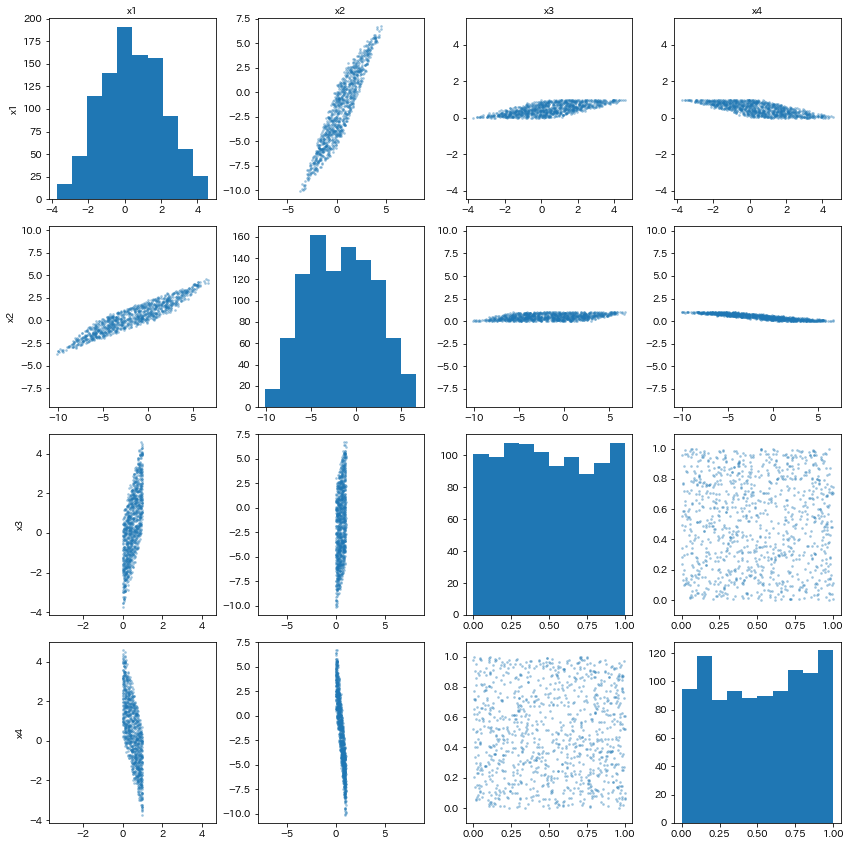

In [24]:
draw_scatter_matrix(data, data)

# Argument precedence

Even if interv_exog or models is set, interv_endog takes precedence.

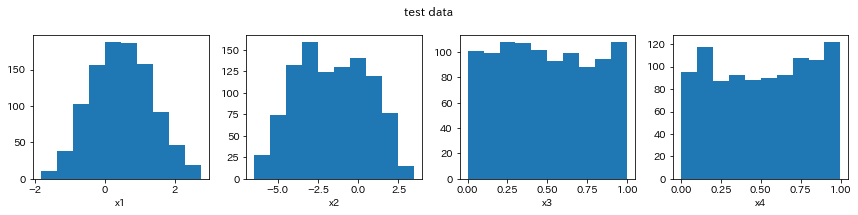

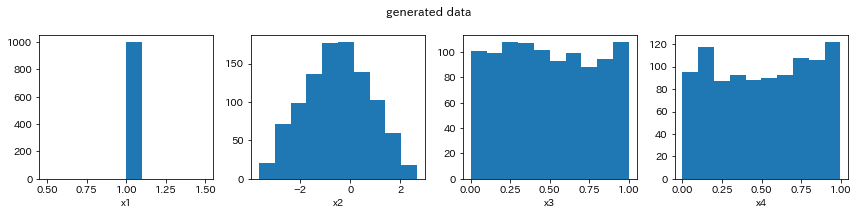

In [25]:
def cause_model(X, error, args):
    generated = X @ args.coef_ + args.intercept_ + 100 + error
    return generated

data = gen.generate(
    # set x1 to 1
    interv_endog={"x1": np.ones(N)},
    # set x1 to 10
    interv_exog={"x1": 10 * np.ones(N)},
    # add 100 to intercept of model of x1
    cause_model=cause_model,
    cause_model_args=gen.model_cause_
)

draw_histogram(X, suptitle="test data")
draw_histogram(data, suptitle="generated data")